In [32]:
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
#import echidna as ec

In [33]:
meta = pd.read_csv("PDAC_IZAR/meta_data.csv", index_col=0)

In [34]:
import os
PATH = "results/"
all_delta_eta = pd.DataFrame()
for patient in os.listdir(PATH):
    if "delta_eta" in patient:
        #print(patient)
        eta = pd.read_csv(PATH+patient, index_col=0)
        all_delta_eta = pd.concat((all_delta_eta, eta),axis=1)

In [35]:
all_ads = []
for patient in os.listdir(PATH):
    if "h5" in patient:
        X = sc.read_h5ad(PATH+patient)
        X.X = X.layers["counts"]
        all_ads.append(X)

In [40]:
adata_orig = sc.concat(all_ads)

In [24]:
adata.write_h5ad("PDAC_combined_raw.h5")

In [27]:
adata.to_df().to_csv("PDAC_combined_raw.csv")

In [37]:
adata = sc.AnnData(pd.read_csv("Seurat_integrated.csv", index_col=0).T)

In [38]:
adata

AnnData object with n_obs × n_vars = 10652 × 2000

In [29]:
adata.obs.to_csv("PDAC_obs.csv")

In [45]:
adata_orig.layers["counts"] = adata_orig.X
sc.pp.calculate_qc_metrics(adata_orig, inplace=True)
adata_orig.obs['original_total_counts'] = adata_orig.obs['total_counts']

# log10 original library size
adata_orig.obs['log10_original_total_counts'] = np.log10(adata_orig.obs['original_total_counts'])

# Normalize by median library size
med = np.median(adata_orig.obs['original_total_counts'])
sc.pp.normalize_total(adata_orig, target_sum = 1)
sc.pp.log1p(adata_orig)

In [39]:
sc.pp.neighbors(adata, n_neighbors=5)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [46]:
adata.obs = adata_orig.obs

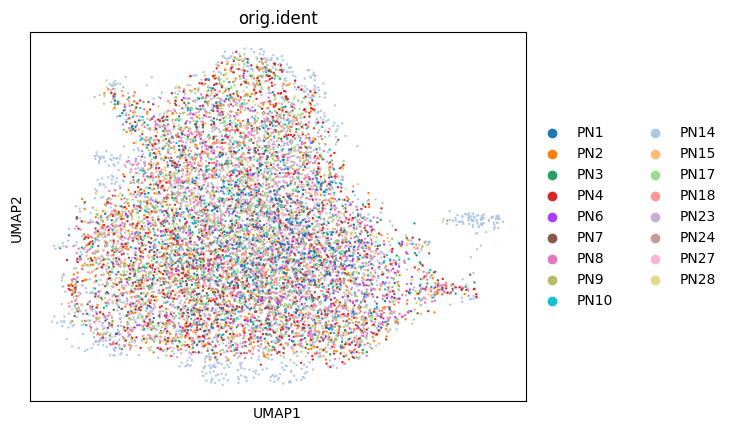

In [43]:
sc.pl.umap(adata, color=["orig.ident"])

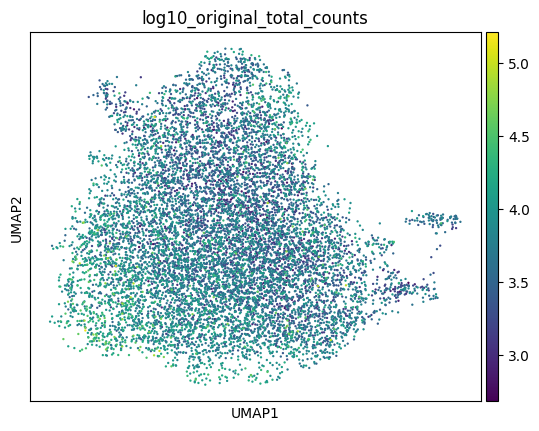

In [47]:
sc.pl.umap(adata, color=['log10_original_total_counts'])

In [48]:
obs = adata.obs
obs["pt_cluster"] = np.asarray(obs["orig.ident"])+np.asarray(["_" for i in range(adata.shape[0])])+np.asarray([str(i) for i in obs["leiden"]])

exp_norm = pd.DataFrame()
df = adata.to_df()
for cl in np.unique(obs["pt_cluster"]):
    exp_norm = pd.concat((exp_norm, pd.DataFrame(df.loc[obs[obs["pt_cluster"]==cl].index].mean(axis=0),columns=[cl])),axis=1)

In [49]:
liv_sig = pd.read_csv("PDAC_IZAR/Liver_signature.txt",sep='\t')
liv_sig = liv_sig[liv_sig["p_val_adj"]<.05]
liv_sig = [i.strip() for i in list(liv_sig["gene"])]

In [50]:
lun_sig = pd.read_csv("PDAC_IZAR/Lung_signature.txt",sep='\t')
lun_sig = lun_sig[lun_sig["p_val_adj"]<.05]
lun_sig = [i.strip() for i in list(lun_sig["gene"])]

In [51]:
obs = adata.obs
mr_dict = {}
for i in np.unique(obs["pt_cluster"]):
    if i not in mr_dict.keys():
        if len(np.unique(obs[obs["pt_cluster"]==i]["condition"]))>1:
            print("multiple conditions per cluster")
        mr_dict[i]= np.unique(obs[obs["pt_cluster"]==i]["condition"])[0]

In [52]:
liv_eta = all_delta_eta.dropna()[[i for i in all_delta_eta.columns if mr_dict[i]=="liver"]]
lun_eta = all_delta_eta.dropna()[[i for i in all_delta_eta.columns if mr_dict[i]=="lung"]]
liv_exp = exp_norm[[i for i in exp_norm.columns if mr_dict[i]=="liver"]]
lun_exp = exp_norm[[i for i in exp_norm.columns if mr_dict[i]=="lung"]]

In [16]:
from statsmodels.stats.multitest import multipletests
def fdr_correction(p_values, alpha=0.05):
    rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')
    return pd.Series(pvals_corrected, index=p_values.index)

In [60]:
df = pd.concat((liv_eta, lun_eta), axis=1).T
df["MR"] = ["liver" for i in range(liv_eta.shape[1])]+["lung" for i in range(lun_eta.shape[1])]

In [69]:
df["patient"]=[i.split("_")[0] for i in df.index]

In [71]:
def adjust_clusters(group, median_clusters=10):
    if len(group) > median_clusters:
        return group.sample(median_clusters, random_state=1)
    else:
        return group.sample(median_clusters, replace=True, random_state=1)

adjusted_df = df.groupby('patient').apply(lambda x: adjust_clusters(x)).reset_index(drop=True)

adjusted_df = df.reset_index(drop=True)

df_features = adjusted_df.iloc[:,:-2].applymap(pd.to_numeric, errors='coerce')
df_features.head()

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_5540/1537957844.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  adjusted_df = df.groupby('patient').apply(lambda x: adjust_clusters(x)).reset_index(drop=True)
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_5540/1537957844.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_features = adjusted_df.iloc[:,:-2].applymap(pd.to_numeric, errors='coerce')


geneName,KIF26B,HNRNPR,GATAD2B,SLC25A24,SDCCAG8,CCNL2,GNB1,PRDM16,CAMTA1,ERRFI1,...,ATRX,BRWD3,POF1B,CHM,DIAPH2,MORF4L2,ALG13,THOC2,XIAP,STAG2
0,-0.040121,-1.176541,-0.675796,-0.003127,-0.438149,0.643023,-0.117433,-1.040882,-0.718058,-0.248397,...,0.216300,-1.217179,-0.555269,0.964751,0.126988,0.061988,-0.456056,0.111903,1.600741,-0.011290
1,1.245628,-0.413508,0.730435,0.307715,-0.264693,-0.644286,1.033933,1.175872,-1.476364,-1.613482,...,-0.720065,0.607462,0.266418,-0.056485,-0.166210,0.609073,-0.067869,1.553688,0.988461,-0.474584
2,0.487448,0.093547,-0.045443,0.016542,-0.165222,-0.325383,0.280876,-0.373442,-0.312230,0.020914,...,-0.237097,-0.122935,0.475762,0.007375,-0.358586,0.065875,-0.440062,-0.590190,-0.286885,0.612518
3,2.272336,0.571091,-0.502322,-1.257161,1.434023,-0.225947,-1.574596,-0.320187,1.250422,0.771947,...,-0.780895,0.404221,-0.288256,0.610413,0.273639,-0.579200,-0.529420,-0.738711,-0.784498,-0.210000
4,-1.010117,-0.051719,0.127661,0.017679,1.485266,0.237134,-0.422683,-0.607495,1.471304,-0.575407,...,-0.595439,-0.027490,-0.556307,-1.667779,0.283983,-0.094306,-0.959189,-1.180680,-0.762189,-0.032989


In [74]:
# positive = enriched in label_1, negative = enriched in label_0
import tqdm
from statsmodels.stats.multitest import multipletests
def permutation_test_signed(df, labels, label_0='label_0', label_1='label_1', num_permutations=1000):
    # Convert string labels to binary labels (0 and 1)
    labels = labels.map({label_0: 0, label_1: 1})
    
    # Function to calculate the test statistic (difference in means)
    def calculate_statistic(df, labels):
        return df[labels == 1].mean() - df[labels == 0].mean()

    # Calculate the observed test statistic
    observed_stats = calculate_statistic(df, labels)
    permuted_stats = np.zeros((num_permutations, observed_stats.shape[0]))

    # Perform permutation test
    for i in tqdm.tqdm((range(num_permutations))):
        permuted_labels = np.random.permutation(labels)
        permuted_stat = calculate_statistic(df, permuted_labels)
        permuted_stats[i, :] = permuted_stat.values

    # Calculate two-sided p-values
    p_values = np.mean(np.abs(permuted_stats) >= np.abs(observed_stats.values), axis=0)
    
    # Create a DataFrame with test statistics and p-values
    results_df = pd.DataFrame({
        'test_statistic': observed_stats,
        'p_value': p_values
    }, index=df.columns)
    
    return results_df
def fdr_correction(p_values, alpha=0.05):
    rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')
    return pd.Series(pvals_corrected, index=p_values.index)

In [77]:
res = permutation_test_signed(df_features, labels=adjusted_df['MR'], label_0="liver", label_1="lung", num_permutations=1000) # ties after 10K permutations
res['p_value_adj'] = fdr_correction(res['p_value'], alpha=0.05)

res = res[res["p_value_adj"]<.05]

res_lun = res[res['test_statistic']>0]
#res_r = res_r.loc[list(np.intersect1d(deg_nr.index, res_r.index))]
res_lun = res_lun.sort_values(by='test_statistic', ascending=False)

res_liv = res[res['test_statistic']<0]
#res_nr = res_nr.loc[list(np.intersect1d(deg.index, res_nr.index))]
res_liv = res_liv.sort_values(by='test_statistic', ascending=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1569.08it/s]


In [83]:
np.intersect1d(res_liv.index, liv_sig)

array(['CCDC50', 'CLTC', 'FRAS1', 'GPATCH8', 'ITGB4', 'MSI2', 'NCEH1',
       'OPA1', 'SENP5', 'SLC39A11', 'VEGFA'], dtype=object)

In [84]:
np.intersect1d(res_lun.index, lun_sig)

array(['MUC1', 'PTPRG', 'S100A6'], dtype=object)

In [85]:
ordered = pd.read_csv("Mori/gene_ordering_file.txt", sep='\t', header=None, index_col=0)

In [86]:
ordered_genes = np.load("ordered_genes.npy")
ordchrs = np.load("ordered_chrs.npy")
pal = {"del":"blue","neut":"grey","amp":"red"}

ordered_genes = ordered.index
ordchrs = ordered[1]

def eta_no_bin(eta):
    inds = []
    draw_lines = []
    ch = 'chr1'
    chr_list = [ch]
    count=0
    for i in range(len(ordered_genes)):
        if ordered_genes[i] in eta.index:
            inds.append(ordered_genes[i])
            count+=1
            if ordchrs[i]!=ch:
                draw_lines.append(count)
                ch=ordchrs[i]
                chr_list.append(ch)
    draw_lines.append(count)
    return draw_lines, chr_list, inds

In [87]:
liv_eta = all_delta_eta[[i for i in all_delta_eta.columns if mr_dict[i]=="liver"]]
lun_eta = all_delta_eta[[i for i in all_delta_eta.columns if mr_dict[i]=="lung"]]

In [88]:
chr_lines, chr_list, genes = eta_no_bin(liv_eta)

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_5540/1581915238.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if ordchrs[i]!=ch:
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_5540/1581915238.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ch=ordchrs[i]


In [27]:
liv_samples = ["PN1","PN10","PN18","PN23","PN27","PN8","PN9",'PN3']
lun_samples = ["PN13","PN14","PN15","PN16","PN17","PN19","PN2","PN24","PN28","PN4","PN5","PN6","PN7"]

In [99]:
import echidna as ec
ec.pl.activate_plot_settings()

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_5540/1581915238.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if ordchrs[i]!=ch:
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_5540/1581915238.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ch=ordchrs[i]
2025-07-03 11:39:25,858 | INFO : maxp pruned
2025-07-03 11:39:25,858 | INFO : LTSH dropped
2025-07-03 11:39:25,859 | INFO : cmap pruned
2025-07-03 11:39:25,859 | INFO : kern dropped
2025-07-03 11:39:25,862 | INFO : post pruned
2025-07-03 11:39:25,862 | INFO : PCLT dropped
2025-07-03 11:39:25,862 | INFO : JSTF dropped
2025-07-03 11:39

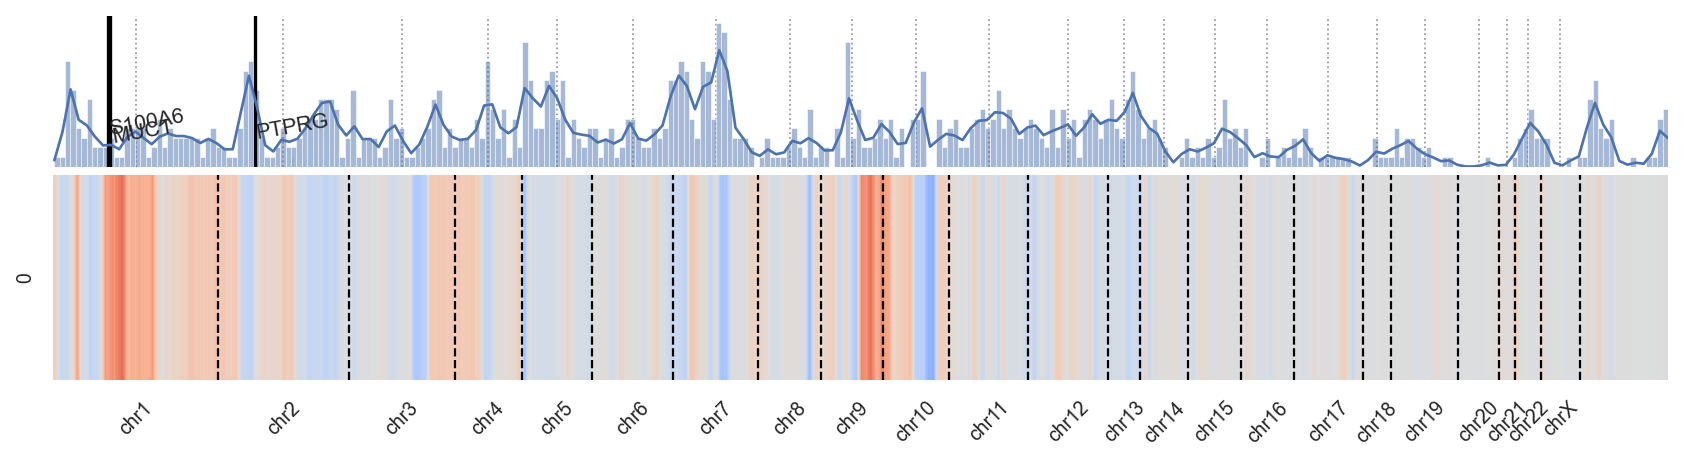

In [147]:
from scipy.signal import find_peaks
from scipy.signal import peak_widths

fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot2grid((23,22), (3,1), colspan=19, rowspan=4)
ax2 = plt.subplot2grid((23,22), (0,1), colspan=19, rowspan=3,sharex = ax1)

plot_degs = np.intersect1d(lun_sig, lun_eta.fillna(0).index)
draw_lines = [list(lun_eta.fillna(0).index).index(i) for i in plot_degs]

chr_lines, chr_list, genes = eta_no_bin(lun_eta.fillna(0))

density = []
for gene in plot_degs:
    density.append(list(lun_eta.fillna(0).index).index(gene))

counts, bin_edges = np.histogram(density, bins=400)

# Extract KDE data
kde_line = ax_hist.get_lines()[0]  # The first line corresponds to the KDE
kde_x = kde_line.get_xdata()
kde_y = kde_line.get_ydata()

smooth = scipy.ndimage.gaussian_filter1d(lun_eta.fillna(0).T.mean(axis=0), sigma=100, radius=10)
sns.heatmap([smooth], cmap='coolwarm', vmin=-1, vmax=1, ax=ax1, cbar=False)
ticklines = []
for i in range(len(chr_lines)):
    ax1.axvline(x=chr_lines[i], color='black', linestyle='--', linewidth=1)
    if i==0:
        ticklines.append(chr_lines[i]-.5*chr_lines[0])
    else:
        ticklines.append(chr_lines[i-1]+.5*(chr_lines[i]-chr_lines[i-1]))
ax1.set_xticks(ticklines, labels=chr_list, rotation=45)

for i in  np.intersect1d(lun_sig, res_lun.index):
    ax2.axvline(x=list(lun_eta.index).index(i), linewidth=1.5, color='black')     
y=2.5
for i in np.intersect1d(lun_sig, res_lun.index):
    ax2.text(list(lun_eta.index).index(i),y,i, rotation=10)
    y+=.4
                

ax2.fill_between(kde_x, 0, kde_y, color='lightblue', alpha=.5)
ax_hist = sns.histplot(density, bins=300, kde=True, kde_kws=dict(bw_adjust=.05))

# Find peaks
peaks, _ = find_peaks(kde_y, prominence=4)

# Find peak widths
results_full = peak_widths(kde_y, peaks, rel_height=0.5)  # Width at half prominence

# Interpolated x-coordinates for the widths
left_coords = results_full[2]
right_coords = results_full[3]

# Convert interpolated coordinates to indices
left_indices = np.round(left_coords).astype(int)
right_indices = np.round(right_coords).astype(int)

#figure out which peaks correspond to amps
hotspot_inds = []
for i in range(len(left_coords)):
    #print(smooth[:,int(round(kde_x[left_indices[i]],0)):int(round(kde_x[right_indices[i]],0))].mean())
    if np.asarray([smooth])[:,int(round(kde_x[left_indices[i]],0)):int(round(kde_x[right_indices[i]],0))].mean()>.5:
        hotspot_inds.append(i)
        
peaks = peaks[hotspot_inds]
left_indices = left_indices[hotspot_inds]
right_indices = right_indices[hotspot_inds]


for i in range(len(left_indices)):
    ax2.fill_between(kde_x[left_indices[i]:right_indices[i]+1], 0, kde_y[left_indices[i]:right_indices[i]+1], color='lightpink')
#ax2.hist(draw_lines, bins=350, color='black', alpha=.2)
ax2.set_yticks([])
ax2.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)  # Remove left spine
ax2.spines["bottom"].set_visible(False)
ax2.set_ylabel(None)
plt.savefig("lung_heatmap.pdf")

In [153]:
print(len(np.intersect1d(lun_sig, lun_eta.index)))
print(len(np.intersect1d(liv_sig, liv_eta.index)))

999
632


/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_5540/1581915238.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if ordchrs[i]!=ch:
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_5540/1581915238.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ch=ordchrs[i]
2025-07-03 11:39:19,954 | INFO : maxp pruned
2025-07-03 11:39:19,955 | INFO : LTSH dropped
2025-07-03 11:39:19,956 | INFO : cmap pruned
2025-07-03 11:39:19,959 | INFO : kern dropped
2025-07-03 11:39:19,961 | INFO : post pruned
2025-07-03 11:39:19,962 | INFO : PCLT dropped
2025-07-03 11:39:19,962 | INFO : JSTF dropped
2025-07-03 11:39

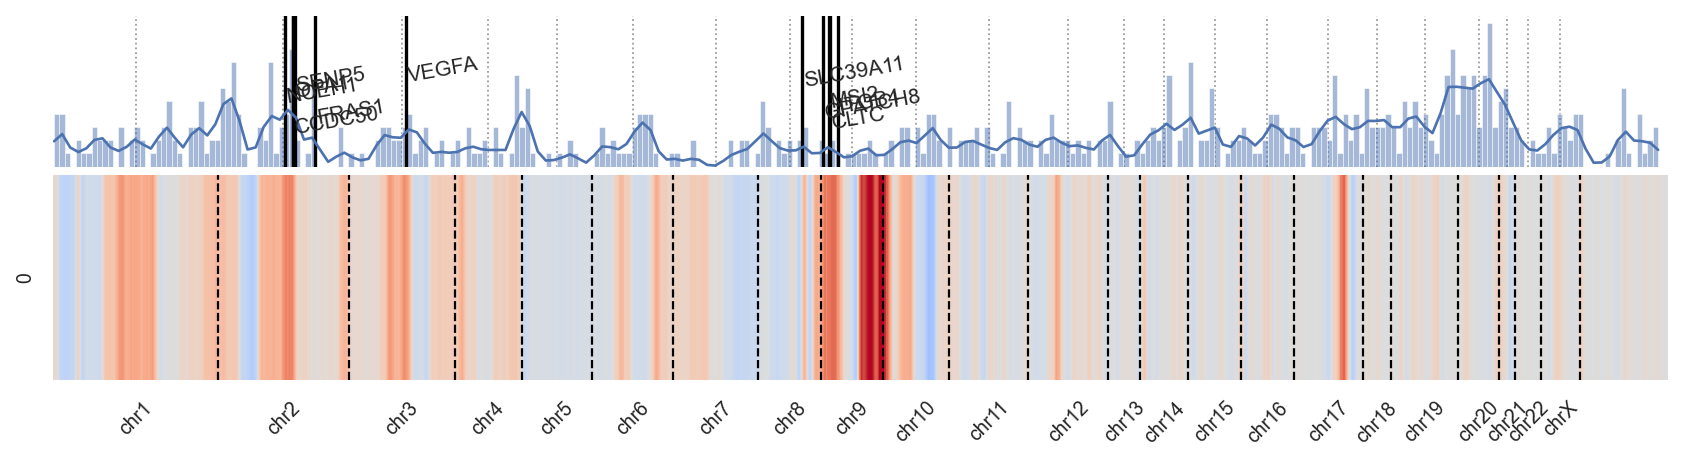

In [146]:
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot2grid((23,22), (3,1), colspan=19, rowspan=4)
ax2 = plt.subplot2grid((23,22), (0,1), colspan=19, rowspan=3,sharex = ax1)

plot_degs = np.intersect1d(liv_sig, liv_eta.fillna(0).index)
draw_lines = [list(liv_eta.fillna(0).index).index(i) for i in plot_degs]

chr_lines, chr_list, genes = eta_no_bin(liv_eta.fillna(0))

density = []
for gene in plot_degs:
    density.append(list(lun_eta.fillna(0).index).index(gene))

counts, bin_edges = np.histogram(density, bins=400)

# Extract KDE data
kde_line = ax_hist.get_lines()[0]  # The first line corresponds to the KDE
kde_x = kde_line.get_xdata()
kde_y = kde_line.get_ydata()

smooth = scipy.ndimage.gaussian_filter1d(liv_eta.fillna(0).T.mean(axis=0), sigma=100, radius=10)
sns.heatmap([smooth], cmap='coolwarm', vmin=-1, vmax=1, ax=ax1, cbar=False)
ticklines = []
for i in range(len(chr_lines)):
    ax1.axvline(x=chr_lines[i], color='black', linestyle='--', linewidth=1)
    if i==0:
        ticklines.append(chr_lines[i]-.5*chr_lines[0])
    else:
        ticklines.append(chr_lines[i-1]+.5*(chr_lines[i]-chr_lines[i-1]))
ax1.set_xticks(ticklines, labels=chr_list, rotation=45)

for i in  np.intersect1d(liv_sig, res_liv.index):
    ax2.axvline(x=list(lun_eta.index).index(i), linewidth=1.5, color='black')     
y=2.5
for i in np.intersect1d(liv_sig, res_liv.index):
    ax2.text(list(lun_eta.index).index(i),y,i, rotation=10)
    y+=.4
                

ax2.fill_between(kde_x, 0, kde_y, color='lightblue', alpha=.5)
ax_hist = sns.histplot(density, bins=300, kde=True, kde_kws=dict(bw_adjust=.05))

# Find peaks
peaks, _ = find_peaks(kde_y, prominence=4)

# Find peak widths
results_full = peak_widths(kde_y, peaks, rel_height=0.5)  # Width at half prominence

# Interpolated x-coordinates for the widths
left_coords = results_full[2]
right_coords = results_full[3]

# Convert interpolated coordinates to indices
left_indices = np.round(left_coords).astype(int)
right_indices = np.round(right_coords).astype(int)

#figure out which peaks correspond to amps
hotspot_inds = []
for i in range(len(left_coords)):
    #print(smooth[:,int(round(kde_x[left_indices[i]],0)):int(round(kde_x[right_indices[i]],0))].mean())
    if np.asarray([smooth])[:,int(round(kde_x[left_indices[i]],0)):int(round(kde_x[right_indices[i]],0))].mean()>.5:
        hotspot_inds.append(i)
        
peaks = peaks[hotspot_inds]
left_indices = left_indices[hotspot_inds]
right_indices = right_indices[hotspot_inds]


for i in range(len(left_indices)):
    ax2.fill_between(kde_x[left_indices[i]:right_indices[i]+1], 0, kde_y[left_indices[i]:right_indices[i]+1], color='lightpink')
#ax2.hist(draw_lines, bins=350, color='black', alpha=.2)
ax2.set_yticks([])
ax2.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)  # Remove left spine
ax2.spines["bottom"].set_visible(False)
ax2.set_ylabel(None)
plt.savefig("liv_heatmap.pdf")